This script tries to develop Regression model for facial keypoint detection. The used dataset is the one below:

https://www.kaggle.com/datasets/nagasai524/facial-keypoint-detection

A mean absolute percentage error of 6% is reached using a EfficientNetB7 based neural network

Resource:

Tan, Mingxing, and Quoc Le. "Efficientnet: Rethinking model scaling for convolutional neural networks." International conference on machine learning. PMLR, 2019.

Reference article: https://arxiv.org/abs/1905.11946

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import csv
from PIL import Image
import random
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
labels_dir = "/kaggle/input/facial-keypoint-detection/training.csv"
X_dir = "/kaggle/input/facial-keypoint-detection/images/"
train_image_dir = "train_images/"
test_image_dir = "test_images/"

In [3]:
#validation set acquirement

pixel_size = (96, 96)

X_valid = []
  
for image in os.listdir(X_dir+test_image_dir):
    img = Image.open(X_dir+test_image_dir+image)
    X_valid.append(np.array(img.resize(pixel_size)))

X_valid = np.array(X_valid)
X_valid = np.array(X_valid, dtype='float32')/255.0
print(f"X_valid length: {X_valid.shape}")

X_valid length: (1783, 96, 96, 3)


In [4]:
#training set, features and label acquirement
Y_train = []
X_train = []
with open(labels_dir) as in_file:
    reader = csv.reader(in_file, delimiter=',')
    skip_line = next(reader)
    for line,image in zip(reader, os.listdir(X_dir+train_image_dir)):
        if('' not in line):
            line = [float(item) for item in line]
            Y_train.append(np.array(line))
            img = Image.open(X_dir+train_image_dir+image)
            X_train.append(np.array(img.resize(pixel_size)))
        else:
            pass

Y_train = np.array(Y_train, dtype='float32')
X_train = np.array(X_train)

print(f"X_train length: {X_train.shape}")
print(Y_train.shape)

X_train length: (2140, 96, 96, 3)
(2140, 30)


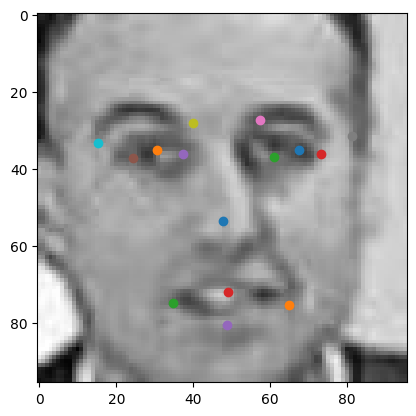

In [5]:
#Training example
img_index = random.randint(0,len(Y_train))
plt.imshow(X_train[img_index])
for index in range(0, len(Y_train[img_index]),2):
    plt.scatter(Y_train[img_index][index], Y_train[img_index][index+1])
plt.show()

In [6]:
#normalization and shape check
X_train = np.array(X_train, dtype='float32')/255.0

print(X_train.shape)
print(X_valid.shape)

(2140, 96, 96, 3)
(1783, 96, 96, 3)


In [7]:
#Model definition and transfer learning
eff_extractor = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(96,96, 3),
    include_top=False,
    weights='imagenet')
eff_extractor.trainable = False

model = tf.keras.models.Sequential()
model.add(eff_extractor)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(2048, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(30, activation='relu', kernel_initializer='he_normal'))


258076736/258076736 [==============================] - 9s 0us/step


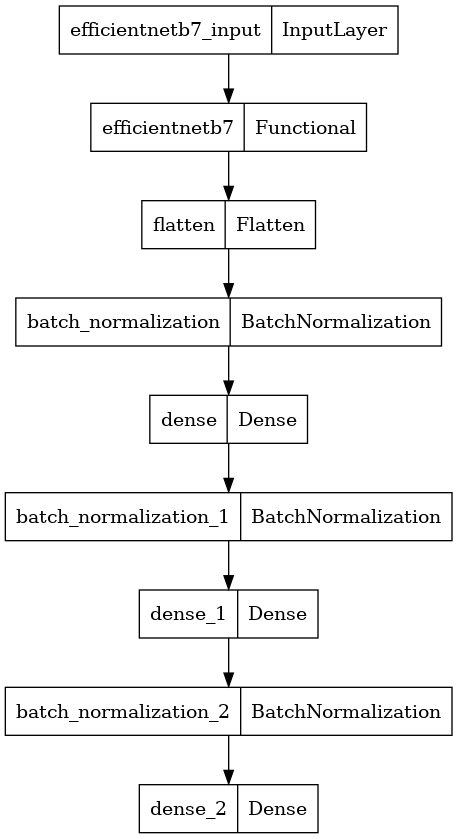

In [8]:
tf.keras.utils.plot_model(model)

In [9]:
model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
        loss='mse',
        metrics=['mae', 'mape'])

In [10]:
epochs_len = 600
history = model.fit(
    X_train, Y_train,
    epochs=epochs_len,
    batch_size=128,
    verbose=1)

Epoch 1/600


2023-10-18 16:30:30.461537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


17/17 [==============================] - 28s 179ms/step - loss: 2459.2795 - mae: 46.0463 - mape: 96.6806
Epoch 2/600
17/17 [==============================] - 3s 178ms/step - loss: 2304.9973 - mae: 44.5087 - mape: 93.5465
Epoch 3/600
17/17 [==============================] - 3s 179ms/step - loss: 2119.7937 - mae: 42.4202 - mape: 89.2411
Epoch 4/600
17/17 [==============================] - 3s 181ms/step - loss: 1899.6058 - mae: 39.5058 - mape: 83.1505
Epoch 5/600
17/17 [==============================] - 3s 177ms/step - loss: 1702.0292 - mae: 36.2834 - mape: 76.4058
Epoch 6/600
17/17 [==============================] - 3s 178ms/step - loss: 1550.4518 - mae: 33.1010 - mape: 69.7408
Epoch 7/600
17/17 [==============================] - 3s 178ms/step - loss: 1465.9094 - mae: 30.6405 - mape: 64.6225
Epoch 8/600
17/17 [==============================] - 3s 178ms/step - loss: 1416.3662 - mae: 28.9068 - mape: 60.9098
Epoch 9/600
17/17 [==============================] - 3s 179ms/step - loss: 1380.483

1/1 [==============================] - 0s 35ms/step


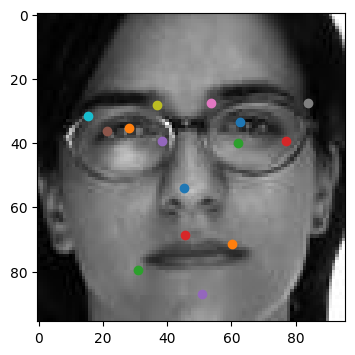

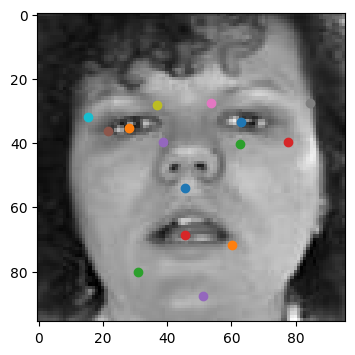

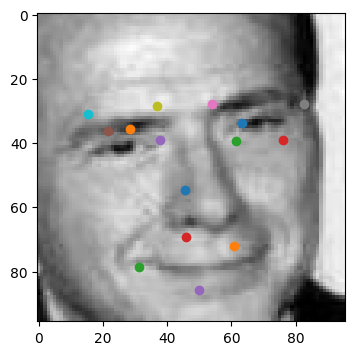

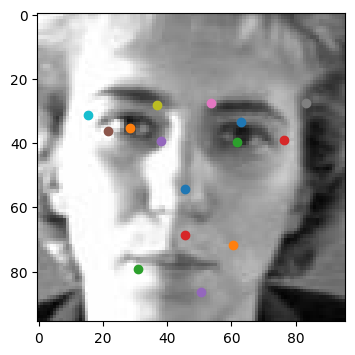

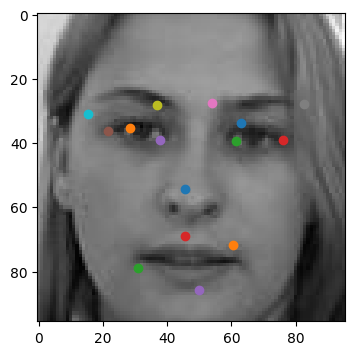

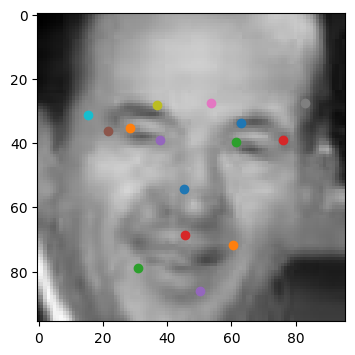

In [11]:
#Play on validation
img_num = 6
fig_s = 4
for index in range(0, img_num):
    plt.figure(index, figsize=(fig_s,fig_s))
    img_index = random.randint(0,len(X_valid))
    predicted_point = model.predict(X_valid[img_index].reshape(1,  96, 96, 3))[0]
    plt.plot(img_num/2, 2, index+1)
    plt.imshow(np.array((X_valid[img_index]*255.0), dtype='uint8'))
    for scatter_index in range(0, len(predicted_point),2):
        plt.scatter(predicted_point[scatter_index], predicted_point[scatter_index+1])

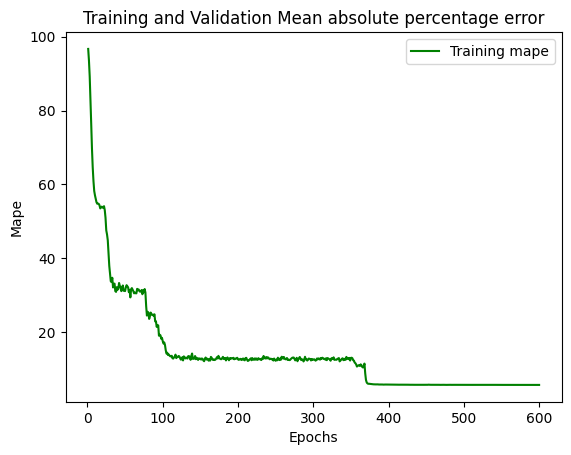

In [12]:
epoch_range = np.arange(1, history.epoch[-1]+2)
train_mape = history.history['mape']

plt.plot(epoch_range, train_mape, 'g', label='Training mape')
plt.title('Training and Validation Mean absolute percentage error')
plt.xlabel('Epochs')
plt.ylabel('Mape')
plt.legend()
plt.show()